In [1]:
# #input
# ingredient_list=["Noodle, Cooked_rice, Paprika"]   # detection한 재료들을 문자열로 표현
# triples_list=["(Noodle, belong to, spaghetti)", "(Shrimp, belong to, Shrimp Burger)"] #각각의 트리플을 문자열로 표현한 list
# top_k=1   # 상위 몇개의 트리플을 가져올것인지

## KAPING

In [10]:
def map_classes_to_ingredients(class_list):
    # 매핑 딕셔너리 생성
    mapping_dict = {
        "Romaine_lettuce": "Lettuce",
        "Yellow_bell_pepper": "Bell pepper",
        "Cooked_rice": "Rice",
        "Vienna_sausage": "Sausage",
        "Soybean_sprouts": "Soybean",
        "Jalapeño": "Jalapeno",
        "Shiitake_mushrooms": "Mushroom",
        "Mung_bean_sprouts": "Soybean",
        "Salmon_sashimi": "Salmon",
        "Slice_cheese": "Cheese",
        "Grilled_beef": "Beef",
        "Sundae_(Korean_sausage)": "Sundae",
        "Enoki_mushrooms": "Mushroom",
        "Canned_tuna": "Tuna",
        "Radish_kimchi": "Radish",
        "Cabbage_kimchi": "Cabbage",
        "Oyster_mushrooms": "Mushroom",
        "Crab_sticks": "Crab",
        "Seasoned_seaweed": "Seaweed",
        "Green_bell_pepper": "Bell pepper",
        "Red_bell_pepper": "Bell pepper",
    }

    # 변환 함수
    ingredient_names = [mapping_dict.get(item, item.replace("_", " ")) for item in class_list]
    return ingredient_names


In [11]:
import json

def load_triples(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

# JSON 파일 경로
filename = "/home/elicer/gnn/triples_list.json"

# Triple 리스트 불러오기
triples_list = load_triples(filename)

# 입력 파라미터 설정
ingredients_list = ["Grilled_beef", "Cooked_rice", "Slice_cheese"]
ingredients_changed_list = map_classes_to_ingredients(ingredients_list)

print(ingredients_changed_list)
top_k=3  # 상위 몇개의 트리플을 가져올것인지


['Beef', 'Rice', 'Cheese']


In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

class MPNetEntityInjector:
    no_knowledge_prompt = "Please answer this question"
    leading_prompt = "Below are facts in the form of the triple meaningful to answer the questions"
    
    def __init__(self, device=-1):
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    def sentence_embedding(self, texts: list):
        return self.model.encode(texts)
    
    def top_k_triple_extractor(self, question: np.ndarray, emb_triples: np.ndarray, real_triples, k=10, random=False):
        """
        Retrieve the top k triples of KGs used as context for the question

        :param question: question in form of sentence embeddings
        :param emb_triples: triples in form of sentence embeddings
        :param real_triples: triples list
        :param k: number of triples to retrieve
        :param random: if this is True, retrieve random knowledge
        :return: list of triples
        """
        # in case number of triples is fewer than k
        if len(emb_triples) < k:
            k = len(emb_triples)
    
        if random:
            return random.sample(real_triples, k)
    
        # if not the baseline but the top k most similar
        similarities = cosine_similarity(question, emb_triples)
        top_k_indices = np.argsort(similarities[0])[-k:][::-1]
    
        return [real_triples[index] for index in top_k_indices]
    
    def injection(self, question: str, triples=None, no_knowledge=False):
        """
        Create prompt based on question and retrieved triples

        :param question: question
        :param triples: list of triples (triples are in string)
        :param no_knowledge: if this is True, only add the no_knowledge_prompt only
        :return:
        """
        # 사용자 의도를 명시적으로 추가
        question_with_context = f"{question}. I'm looking for healthy food options."
    
        if no_knowledge:
            return f"{MPNetEntityInjector.no_knowledge_prompt} Question: {question_with_context} Answer: "
        else:
            if triples:
                response_details = f"{MPNetEntityInjector.leading_prompt} "
                explanations = []
                for triple in triples:
                    item, category, usage = triple.split(", ")
                    explanations.append(
                        f"- {item.strip()}: commonly used in {category.strip()}. Try it in {usage.strip()} for a delicious and healthy option."
                    )
                detailed_response = " ".join(explanations)
                return f"{response_details} {detailed_response} Question: {question_with_context}."
            else:
                return f"{MPNetEntityInjector.leading_prompt} No relevant information available. Question: {question_with_context}."
    
    def __call__(self, question: list, triples: list, k=10, random=False, no_knowledge=False):
        """
        Retrieve the top k triples of KGs used as context for the question

        :param question: 1 question in form [question]
        :param triples: list of triples
        :param k: number of triples to retrieve
        :param random: whether to retrieve random knowledge instead of KAPING
        :param no_knowledge: whether to not use any extra knowledge at all
        :return:
        """
        if no_knowledge:
            return self.injection(question, no_knowledge=True)
    
        # use MPNET to turn all into sentence embeddings
        emb_question = self.sentence_embedding(question)
        emb_triples = self.sentence_embedding(triples)
    
        # retrieve the top k triples
        top_k_triples = self.top_k_triple_extractor(emb_question, emb_triples, triples, k=k, random=random)
    
        # create prompt as input
        return self.injection(question, top_k_triples)

injector = MPNetEntityInjector(device="cuda")
kaping_prompt = injector(question=ingredients_changed_list, triples=triples_list, k=top_k, random=False, no_knowledge=False)
print(kaping_prompt)


Below are facts in the form of the triple meaningful to answer the questions  - (Beef: commonly used in belongs to class. Try it in Sopes With Shredded Beef) for a delicious and healthy option. - (Beef: commonly used in belongs to class. Try it in Slow Roast Corned Beef) for a delicious and healthy option. - (Beef: commonly used in belongs to class. Try it in Pasta With Sliced Beef ) for a delicious and healthy option. Question: ['Beef', 'Rice', 'Cheese']. I'm looking for healthy food options..


## Option 1: Use Llama

In [1]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "Based on the provided knowledge graph triples, suggest potential completed dishes that can be made using the input ingredients. Here are examples: 'Below are facts in the form of the triple meaningful to answer the questions (Shrimp, belong to, Shrimp Burger) Question: what can we make with [Shrimp, Cooked_rice]? Answer: Shrimp Burger'"},
    {"role": "user", "content": "Below are facts in the form of the triple meaningful to answer the questions (Noodle, belong to, spaghetti) Question: what can we make with [Noodle, Cooked_rice, Paprika]? Answer: "},
]
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'role': 'assistant', 'content': 'Based on the given triples, we can infer the following relationships:\n\n- Noodle belongs to Spaghetti\n- Noodle can be paired with Cooked_rice\n- Paprika is an ingredient in Spaghetti\n\nUsing these relationships, we can suggest the following potential completed dishes that can be made using the input ingredients:\n\n- Spaghetti with Cooked_rice and Paprika\n- Spaghetti with Cooked_rice, but without Paprika (since Paprika is not a required ingredient)\n- However, we cannot make a dish using only Noodle and Cooked_rice, as Noodle belongs to Spaghetti.'}


In [11]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "Based on the provided knowledge graph triples, suggest potential completed dishes that can be made using the input ingredients. Here are examples: 'Below are facts in the form of the triple meaningful to answer the questions (Shrimp, belong to, Shrimp Burger) Question: what can we make with [Shrimp, Cooked_rice]? Answer: Shrimp Burger'"},
    {"role": "user", "content": "Below are facts in the form of the triple meaningful to answer the questions (Noodle, belong to, spaghetti) Question: what can we make with [Noodle, Cooked_rice, Paprika]? Answer: "},
]
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'role': 'assistant', 'content': "Based on the given triple (Noodle, belong to, spaghetti), we can infer that Noodle is similar to Spaghetti. However, we cannot directly conclude a specific dish using Noodle, Cooked_rice, and Paprika.\n\nBut, considering the triple (Shrimp, belong to, Shrimp Burger), we can make an educated guess. Since Noodle is similar to Spaghetti, and Spaghetti is often paired with dishes like Bolognese or Carbonara, we can suggest a potential dish:\n\nOne possible dish that can be made using Noodle, Cooked_rice, and Paprika is a 'Paprika Noodle Stir-Fry'."}


# Option 2 : Use Llama another way

In [14]:
!pip install ollama

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [15]:
import ollama, os

In [16]:
modelfile="""
FROM Meta-Llama-3-70B-Instruct.Q3_K_M.gguf
"""

In [17]:
ollama.create(model='llama3:70b', modelfile=modelfile)

{'status': 'success'}

## 각 레시피에 대한 칼로리를 api를 통해 업데이트

In [11]:
import requests

def get_nutrition(ingredient, api_key):
    url = f'https://api.calorieninjas.com/v1/nutrition?query={ingredient}'
    headers = {'X-Api-Key': api_key}
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data['items']:
                return data['items'][0]
            else:
                return {'error': 'No nutritional data found'}
        else:
            return {'error': 'API call failed with status code ' + str(response.status_code)}
    except requests.exceptions.RequestException as e:
        return {'error': str(e)}


In [ ]:
def get_processed_ids(output_path):
    processed_ids = set()
    try:
        with open(output_path, 'r', encoding='utf-8') as file:
            for line in file:
                json_obj = json.loads(line)
                processed_ids.add(json_obj["id"])
    except FileNotFoundError:
        pass  # 파일이 존재하지 않는 경우 새로 시작.
    return processed_ids

def update_jsonl_with_nutrition(file_path, output_path, api_key):
    processed_ids = get_processed_ids(output_path)  # 이미 처리된 ID 가져오기
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line)
            if json_obj["id"] in processed_ids:
                continue  # 이미 처리된 항목이면 건너뛰기.
            
            text_data = json_obj['text']
            title = text_data.split("\n")[0].replace("Title: ", "").strip()
            raw_ingredients = eval(text_data.split("\n")[1].replace("Ingredients: ", "").strip())
            directions = eval(text_data.split("\n")[2].replace("Directions: ", "").strip())
            
            ingredients = []
            for item in raw_ingredients:
                ingredient_name = item  # 가정: 항목은 문자열입니다.
                nutrition = get_nutrition(ingredient_name, api_key)  # 영양 정보 가져오기
                if nutrition is None:  # 영양 정보가 없는 경우
                    nutrition = "Nutrition data not available"
                ingredients.append({'name': ingredient_name, 'nutrition': nutrition})
            
            updated_recipe = {
                "id": json_obj["id"],
                "title": title,
                "ingredients": ingredients,
                "directions": directions
            }

            # 업데이트된 레시피를 출력 파일에 추가
            with open(output_path, 'a', encoding='utf-8') as outfile:
                json.dump(updated_recipe, outfile)
                outfile.write('\n')


# Usage
file_path = '/home/elicer/ollama/full_dataset_processed.jsonl'
output_path = '/home/elicer/ollama/calories_included_dataset.jsonl'
api_key = 'QScKg+CBIb4GKQkC7XFaJA==6KoWb91xfCoRs6Be'
update_jsonl_with_nutrition(file_path, output_path, api_key)

## 위의 작업이 완료되지 않았기에 우선적으로 먼저 만들어진 jsonl 데이터로 dataframe 구성

In [18]:
#jsonl data preprocessing
import pandas as pd
import json

#jsonl 파일 경로
file_path = "/home/elicer/ollama/full_dataset_processed.jsonl"

#jsonㅣ 파일 정보
"""
{"id": "0", "text": "Title: No-Bake Nut Cookies\nIngredients: [\"1 c. firmly packed brown sugar\", \"1/2 c. evaporated milk\", \"1/2 tsp. vanilla\", \"1/2 c. broken nuts (pecans)\", \"2 Tbsp. butter or margarine\", \"3 1/2 c. bite size shredded rice biscuits\"]\nDirections: [\"In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.\", \"Stir over medium heat until mixture bubbles all over top.\", \"Boil and stir 5 minutes more. Take off heat.\", \"Stir in vanilla and cereal; mix well.\", \"Using 2 teaspoons, drop and shape into 30 clusters on wax paper.\", \"Let stand until firm, about 30 minutes.\"]"}
{"id": "1", "text": "Title: Jewell Ball'S Chicken\nIngredients: [\"1 small jar chipped beef, cut up\", \"4 boned chicken breasts\", \"1 can cream of mushroom soup\", \"1 carton sour cream\"]\nDirections: [\"Place chipped beef on bottom of baking dish.\", \"Place chicken on top of beef.\", \"Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\u00b0 for 3 hours.\"]"}
{"id": "2", "text": "Title: Creamy Corn\nIngredients: [\"2 (16 oz.) pkg. frozen corn\", \"1 (8 oz.) pkg. cream cheese, cubed\", \"1/3 c. butter, cubed\", \"1/2 tsp. garlic powder\", \"1/2 tsp. salt\", \"1/4 tsp. pepper\"]\nDirections: [\"In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings.\"]"}
{"id": "3", "text": "Title: Chicken Funny\nIngredients: [\"1 large whole chicken\", \"2 (10 1/2 oz.) cans chicken gravy\", \"1 (10 1/2 oz.) can cream of mushroom soup\", \"1 (6 oz.) box Stove Top stuffing\", \"4 oz. shredded cheese\"]\nDirections: [\"Boil and debone chicken.\", \"Put bite size pieces in average size square casserole dish.\", \"Pour gravy and cream of mushroom soup over chicken; level.\", \"Make stuffing according to instructions on box (do not make too moist).\", \"Put stuffing on top of chicken and gravy; level.\", \"Sprinkle shredded cheese on top and bake at 350\\u00b0 for approximately 20 minutes or until golden and bubbly.\"]"}
{"id": "4", "text": "Title: Reeses Cups(Candy)\nIngredients: [\"1 c. peanut butter\", \"3/4 c. graham cracker crumbs\", \"1 c. melted butter\", \"1 lb. (3 1/2 c.) powdered sugar\", \"1 large pkg. chocolate chips\"]\nDirections: [\"Combine first four ingredients and press in 13 x 9-inch ungreased pan.\", \"Melt chocolate chips and spread over mixture. Refrigerate for about 20 minutes and cut into pieces before chocolate gets hard.\", \"Keep in refrigerator.\"]"}
"""

#jsonl to pandas dataframe 으로 변환
data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        json_obj = json.loads(line)
        # "text" 필드를 파싱
        text_data = json_obj['text']
        title = text_data.split("\n")[0].replace("Title: ", "").strip()
        ingredients = eval(text_data.split("\n")[1].replace("Ingredients: ", "").strip())
        directions = eval(text_data.split("\n")[2].replace("Directions: ", "").strip())
        data.append({
            "id": json_obj["id"],
            "title": title,
            "ingredients": ingredients,
            "directions": directions
        })


#Dataframe 생성
df = pd.DataFrame(data)

# 데이터 확인
print(df.head())

  id                  title  \
0  0    No-Bake Nut Cookies   
1  1  Jewell Ball'S Chicken   
2  2            Creamy Corn   
3  3          Chicken Funny   
4  4     Reeses Cups(Candy)   

                                         ingredients  \
0  [1 c. firmly packed brown sugar, 1/2 c. evapor...   
1  [1 small jar chipped beef, cut up, 4 boned chi...   
2  [2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c...   
3  [1 large whole chicken, 2 (10 1/2 oz.) cans ch...   
4  [1 c. peanut butter, 3/4 c. graham cracker cru...   

                                          directions  
0  [In a heavy 2-quart saucepan, mix brown sugar,...  
1  [Place chipped beef on bottom of baking dish.,...  
2  [In a slow cooker, combine all ingredients. Co...  
3  [Boil and debone chicken., Put bite size piece...  
4  [Combine first four ingredients and press in 1...  


In [20]:
#KAPING result prompt 수정
import re
def extract_foodTitle_from_prompt(prompt):
    # Improved regex pattern to exclude the closing parenthesis
    pattern = r'Try it in (.*?)(?:\) for a delicious)'  # Non-capturing group to exclude the parenthesis
    foodTitles = re.findall(pattern, prompt)
    return foodTitles


def retrieve_recipes_by_ingredients(df, kaping_results): 
    """"
    df : foodName title, ingredients, directions
    kaping_results : KAPING - top k로 나온 foodName results
    """
    matched_recipes = []
    for title in kaping_results:
        for _, row in df.iterrows():
            if title.lower() in row['title'].lower():
                matched_recipes.append(row.to_dict())
    return matched_recipes
    
food_titles = extract_foodTitle_from_prompt(kaping_prompt)
print(food_titles)
matched_recipes = retrieve_recipes_by_ingredients(df, food_titles)
# print(matched_recipes)

['Sopes With Shredded Beef', 'Slow Roast Corned Beef', 'Pasta With Sliced Beef ']


In [21]:
!pip install fuzzywuzzy python-Levenshtein


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [22]:
### 대체자 찾기 
### 해당 ingredients가 csv 파일에 완벽히 일치 안 할 수가 있기에 다른 fuzzywuzzy 사용
import pandas as pd
from fuzzywuzzy import process

def load_substitution_data(filepath):
    """ Load substitution data from a CSV file into a DataFrame with categories. """
    df = pd.read_csv(filepath)
    return df

def find_best_substitute(ingredient, substitution_df):
    """
    Find the closest match for an ingredient from the substitution data.
    
    Parameters:
    ingredient (str): The ingredient to find a substitute for.
    substitution_df (DataFrame): DataFrame with 'Ingredient' and 'Substitute'.
    
    Returns:
    str: The best substitute if a suitable one is found; otherwise, None.
    """
    matches = process.extractOne(ingredient.lower(), substitution_df['Ingredient'].str.lower(), score_cutoff=80)
    if matches:
        best_match = matches[0]
        substitute = substitution_df.loc[substitution_df['Ingredient'].str.lower() == best_match, 'Substitute'].values[0]
        return substitute
    return "no suitable substitute found"

def generate_prompt(ingredients, substitution_df):
    """ Generate a cooking prompt including ingredient substitutes if available. """
    prompt = "Here's a recipe you can try with the ingredients you have:\n"
    for ingredient in ingredients:
        substitute = find_best_substitute(ingredient, substitution_df)
        if substitute != "no suitable substitute found":
            prompt += f"- {ingredient} (or substitute with {substitute})\n"
        else:
            prompt += f"- {ingredient} (no suitable substitute found)\n"
    return prompt


# Path to the CSV file
filepath = '/home/elicer/gnn/ingredients_substituter.csv'

# Load substitution data
substitution_df = load_substitution_data(filepath)

# Generate the cooking prompt
substitute_prompt = generate_prompt(ingredients_changed_list, substitution_df)

print(substitute_prompt)


Here's a recipe you can try with the ingredients you have:
- Beef (or substitute with Buffalo)
- Rice (or substitute with Quinoa)
- Cheese (or substitute with Nutritional yeast)



In [25]:
print(matched_recipes)

[{'id': '998354', 'title': 'Sopes With Shredded Beef', 'ingredients': ['Shredded Beef', '3 lbs boneless beef chuck, cut into 2-inch pieces', '1/2 cup lime juice, freshly squeezed', '1/4 cup orange juice, freshly squeezed', '3 tablespoons chili powder', '1 tablespoon ground cumin', '1 tablespoon kosher salt', '2 teaspoons ground coriander', '3 garlic cloves, crushed', 'Tomatillo Guacamole', '3/4 cup coarsely chopped fresh cilantro', '6 -8 tomatillos, husked and coarsely chopped (about 8 ounces)', '2 garlic cloves, smashed, peeled and quartered', '1 avocado, halved, pitted, peeled and diced', '1/2 jalapeno, coarsely chopped with seeds', '1/2 onion, coarsely chopped', '1 lime, juice of', '1 teaspoon ground cumin', '1 teaspoon salt', 'Sopes', '3 cups masa harina', '1/4 cup all-purpose flour, plus more for dusting', '1 teaspoon baking powder', '1 teaspoon salt, plus more for finishing', '2 cups warm water', 'vegetable oil, for frying', 'Toppings', '2 tablespoons unsalted butter', '1 (16 oun

In [26]:
import re

##LLaMA 모델 기반 프롬프트
if matched_recipes:
    for recipe in matched_recipes:
        ingredient_descriptions = ', '.join(recipe['ingredients'])
        # 기존 레시피에서 중복된 번호가 있으면 제거
        cleaned_directions = [re.sub(r'^\d+\.\s*', '', step) for step in recipe['directions']]
        
        # 프롬프트 생성
        prompt = f"""
        Based on the provided ingredients, create a detailed recipe as follows:
    
        Title: {recipe['title']}

        Detected Ingredients : {', '.join(ingredients_changed_list)}
        
        Ingredients:
        {ingredient_descriptions}
    
        Directions:
        {chr(10).join([f"{i+1}. {step}" for i, step in enumerate(cleaned_directions)])}
    
        Please note:
        1. Begin the response with the recipe title.
        2. List all the 'ingredients' used in this recipe in a single line, including substitutes in parentheses, and specify the exact quantity for each ingredient. Example format: "flour - 2 cups, sugar (honey) - 100g".
        3. Provide the step-by-step instructions for this recipe in a clear and numbered format, where each step starts on a new line.
        4. Write a concise one-sentence 'summary of this recipe' that highlights its main ingredients and the core idea of the preparation process.
           Ensure the summary is detailed enough for someone unfamiliar with this dish to understand and visualize the final result.
        5. Include references to substitutions where applicable: {substitute_prompt}
        6. Refer to specific dietary requirements or cooking tips as highlighted in the following guide: {kaping_prompt}
    
        Please format your response strictly following the structure above. Each ingredient and direction should be clearly listed and numbered as specified. 
        """


In [27]:
ollama.generate(model='llama3:70b', prompt=prompt)['response']

'Here is the recipe:\n\n**Slow Roast Corned Beef**\n\nIngredients: Corned beef - 1 1/4 kg, grainy mustard - 2 tablespoons, marmalade - 3 tablespoons, lemon juice - 1/2, garlic clove (crushed or minced) - 1, ground black pepper - 1/4 teaspoon, olive oil - 2 tablespoons, Salad -, eggs - 2 (boiled, peeled, broken in chunks), green beans - 175 g (baby, blanched), tiny new potatoes - 500 g (steamed), mayonnaise - 1/2 cup (whole egg), lemon juice - 1/2, Rice -(or substitute with Quinoa) -, Cheese -(or substitute with Nutritional yeast) -\n\nDirections:\n\n1. FOR CORNED BEEF.\n2. Preheat oven to 220°C.\n3. Combine grainy mustard, marmalade, lemon juice, garlic, ground black pepper and olive oil in a small bowl and mix well together.\n4. Place beef in a baking dish.\n5. Make 6 small slits in the beef and poke a whole clove in each one.\n6. Smother the corned beef with the marmalade mixture.\n7. Put into oven and roast for 10 minutes, drop temperature to 140°C and roast for a further 3 hours, b

In [30]:
!pip install diffusers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.8 MB/s eta 0:00:00


In [34]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
from IPython.display import display

Generated Prompt: A delicious and appetizing 4K photo of Sopes With Shredded Beef, ultra-detailed, food photography, high resolution, well-lit, vibrant colors, cinematic lighting


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

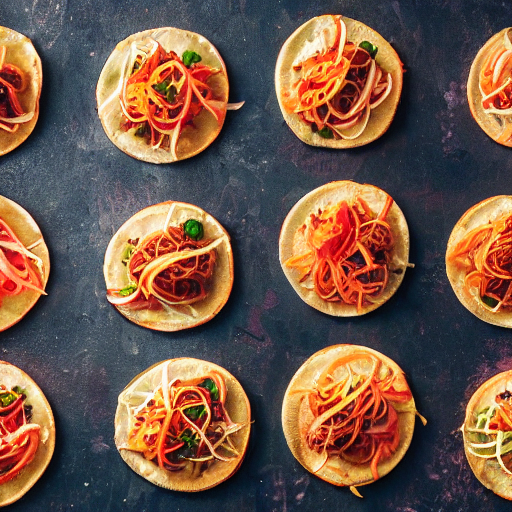

Generated Prompt: A delicious and appetizing 4K photo of Slow Roast Corned Beef, ultra-detailed, food photography, high resolution, well-lit, vibrant colors, cinematic lighting


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

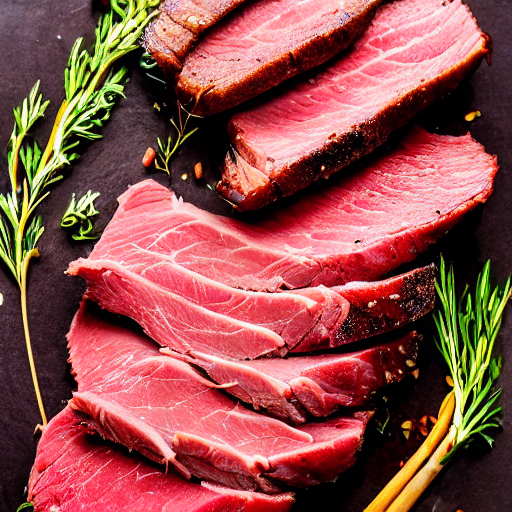

In [32]:
if matched_recipes:
    for recipe in matched_recipes:
        food_name = recipe['title']
        
        # 프롬프트 생성 함수
        def generate_prompt(food_name):
            # 고화질 및 디테일 강화 프롬프트 템플릿
            prompt_template = (
                f"A delicious and appetizing 4K photo of {food_name}, "
                "ultra-detailed, food photography, high resolution, well-lit, vibrant colors, cinematic lighting"
            )
            return prompt_template
        
        prompt = generate_prompt(food_name)
        print(f"Generated Prompt: {prompt}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Stable Diffusion 모델 로드 및 디바이스 이동
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16
        ).to(device)
        
        # 음식 이미지 생성
        image = pipe(prompt).images[0]
        
        # 생성된 이미지 저장 (음식 이름을 포함)
        output_file_name = f"{food_name.replace(' ', '_')}.png"
        image.save(output_file_name)
        
        # 이미지 로드 및 출력
        image = Image.open(output_file_name)
        display(image)

## Generated Text evaluation

In [35]:
!pip install code_bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for code_bert_score: filename=code_bert_score-0.4.1-py3-none-any.whl size=22069 sha256=ae39c94e0831bb236b7f3b6b553e9a4ac0358f7484e258a56d6f7d5109ee4e4d
  Stored in directory: /home/elicer/.cache/pip/wheels/26/ea/cb/0ddb50c1baacd77c6ea15e3df5862070bee90e7e9bef2150d0
Successfully built code_bert_score


In [36]:
# check your installation
import code_bert_score
code_bert_score.__version__

'0.3.5'

In [37]:
# hide the loading messages
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["xtick.major.size"] = 0
rcParams["xtick.minor.size"] = 0
rcParams["ytick.major.size"] = 0
rcParams["ytick.minor.size"] = 0

rcParams["axes.labelsize"] = "large"
rcParams["axes.axisbelow"] = True
rcParams["axes.grid"] = True

In [39]:
from code_bert_score import score

In [40]:
from code_bert_score import plot_example

In [65]:
# Assuming matched_recipes contains at least one recipe and ingredients_changed_list is defined
cands = [
    """Here is the recipe:

    **Slow Roast Corned Beef**

    Ingredients: 
    - Corned beef - 1 1/4 kg, 
    - Grainy mustard - 2 tablespoons, 
    - Marmalade - 3 tablespoons, 
    - Lemon juice - 1/2, 
    - Garlic clove (crushed or minced) - 1, 
    - Ground black pepper - 1/4 teaspoon, 
    - Olive oil - 2 tablespoons, 
    - Eggs - 2 (boiled, peeled, broken in chunks), 
    - Green beans - 175 g (baby, blanched), 
    - Tiny new potatoes - 500 g (steamed), 
    - Mayonnaise - 1/2 cup (whole egg), 
    - Rice (or substitute with Quinoa), 
    - Cheese (or substitute with Nutritional yeast)

    Directions:
    FOR CORNED BEEF.
    1. Preheat oven to 220°C.
    2. Combine grainy mustard, marmalade, lemon juice, garlic, ground black pepper and olive oil in a small bowl and mix well together.
    3. Place beef in a baking dish.
    4. Make 6 small slits in the beef and poke a whole clove in each one.
    5. Smother the corned beef with the marmalade mixture.
    6. Put into oven and roast for 10 minutes, drop temperature to 140°C and roast for a further 3 hours, basting occasionally.
    7. Remove from heat and let rest, covered in foil, for 30 minutes.
    8. Serve with salad.

    FOR THE SALAD.
    9. Place eggs, beans and potatoes in a bowl.
    10. Mix mayonnaise and lemon juice well together.
    11. Toss mayonnaise mixture through the salad.
    12. Serve with corned beef.

    Summary: This recipe for Slow Roast Corned Beef is a flavorful and tender dish that combines the richness of corned beef with a tangy marmalade glaze, served alongside a fresh salad of boiled eggs, blanched green beans, and steamed new potatoes, all tied together with a creamy mayonnaise dressing.

    Note: You can try this recipe as a healthy option, substituting Beef with Buffalo if needed. Additionally, you can replace Rice with Quinoa and Cheese with Nutritional yeast for alternative dietary requirements."""
]

# Generate references from matched_recipes
if matched_recipes:
    refs = [
        f"Based on the provided ingredients, create a detailed recipe as follows:\n\n"
        f"Title: {recipe['title']}\n\n"
        f"Detected Ingredients: {', '.join(ingredients_changed_list)}\n\n"
        f"Ingredients: {', '.join(recipe['ingredients'])}\n\n"
        f"Directions: {chr(10).join([f'{i + 1}. {step}' for i, step in enumerate(recipe['directions'])])}\n\n"
        f"Please note:\n"
        f"1. Begin the response with the recipe title.\n"
        f"2. List all the 'ingredients' used in this recipe in a single line, including substitutes in parentheses, and specify the exact quantity for each ingredient.\n"
        f"3. Provide the step-by-step instructions for this recipe in a clear and numbered format, where each step starts on a new line.\n"
        f"4. Write a concise one-sentence 'summary of this recipe' that highlights its main ingredients and the core idea of the preparation process.\n"
        f"5. Include references to substitutions where applicable: {substitute_prompt}\n"
        f"6. Refer to specific dietary requirements or cooking tips as highlighted in the following guide: {kaping_prompt}\n\n"
        f"Please format your response strictly following the structure above. Each ingredient and direction should be clearly listed and numbered as specified."
        for recipe in matched_recipes[:len(cands)]  # Match the length of `cands`
    ]

    if len(cands) == len(refs):
        P, R, F1, f3 = score(cands, refs, lang='en', verbose=True)
        print(f"Precisions: {P.tolist()}, Recalls: {R.tolist()}, F1 Scores: {F1.tolist()}, F3 Scores : {F3.tolist()}")
    else:
        print(f"Mismatch in the number of candidates ({len(cands)}) and references ({len(refs)}).")
else:
    print("No matched recipes found.")


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.16 seconds, 6.44 sentences/sec
Precisions: [0.8034799098968506], Recalls: [0.762123703956604], F1 Scores: [0.7822555303573608], F3 Scores : [0.7669809460639954]


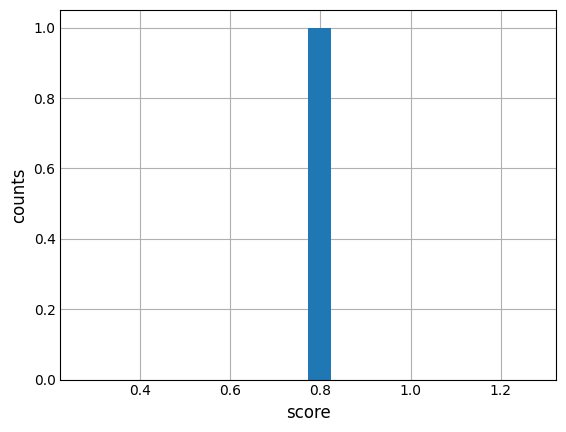

In [52]:
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [ ]:
truncated_cand = cands[0][:1000]  # Truncate to the first 1000 characters
truncated_ref = refs[0][:1000]

plot_example(truncated_cand, truncated_ref, lang="en")
